In [1]:
import re
import gensim
import logging
import pandas as pd
import urllib.request
from gensim.models import word2vec

In [2]:
from tqdm import tqdm
from pymystem3 import Mystem
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def W2V():

    # Загрузка готовой модели из базы RusVectores

    urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz",
                           "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

    m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'

    if m.endswith('.vec.gz'):
        model = gensim.models.KeyedVectors.load_word2vec_format\
        (m, binary=False)
    elif m.endswith('.bin.gz'):
        model = gensim.models.KeyedVectors.load_word2vec_format\
        (m, binary=True)
    else:
        model = gensim.models.KeyedVectors.load(m)

    return model

In [4]:
def GraphNodes(words, model):

    # Находим соседей первого уровня

    first_nn = []
    dict_all = {}
    heap = set()
    for word in words:
        if word in model:
            for i in model.most_similar(positive=[word], topn=10):
                if i[1] >= 0.5 and re.search('_S', i[0]):
                    neig = i[0]
                    if word not in dict_all:
                        dict_all[word] = []
                    else:
                        dict_all[word].append(neig)

                    # слово + коэффициент косинусной близости

                    first_nn.append((word, neig))
                    heap.add(neig)

    return heap, first_nn

In [5]:
def GraphSecond(heap, model, first_nn):

    # Находим соседей второго уровня

    heap2 = set()
    for word in heap:
        if word in model:
            for i in model.most_similar(positive=[word], topn=10):
                if i[1] >= 0.5 and re.search('_S', i[0]):
                    neig = i[0]
                    first_nn.append((word, neig))
                    heap2.add(neig)

    return heap2, first_nn

In [6]:
def ClearEdges(first_nn):

    # Убираем теги частей речи из лэйблов узлов

    clear_edges = []
    for i in first_nn:
        a = re.sub('_S', '', i[0])
        b = re.sub('_S', '', i[1])
        clear_edges.append((a, b))

    return clear_edges

In [7]:
def GraphPlot(edges):

    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.kamada_kawai_layout(G, scale=5)
    plt.figure(figsize=(15, 10))

    # Красим узлы графа в зависимости от центральности узлов от 0 до 1

    nx.draw(G, pos, node_color=np.arange(len(G.nodes)), \
            node_size=800, cmap=plt.cm.Blues.reversed())
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='Arial')
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, \
                               norm=plt.Normalize(vmin=1, vmax=0))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Degree centrality', rotation=270)
    plt.axis('off')
    plt.title('Граф существительных семантического поля "море"')
    plt.show()

    return G

In [8]:
def Centrality(G):

    # Degree centrality также отражена цветом на графике

    print('Degree centrality: ')
    deg = nx.degree_centrality(G)
    for nodeid in sorted(deg, key=deg.get, reverse=True)[:10]:
        print(nodeid)

    print('\n\n','Betweenness centrality: ')
    bet = nx.betweenness_centrality(G)
    for nodeid in sorted(bet, key=bet.get, reverse=True)[:10]:
        print(nodeid)

    print('\n\n','Closeness: ')
    cls = nx.closeness_centrality(G)
    for nodeid in sorted(cls, key=cls.get, reverse=True)[:10]:
        print(nodeid)

    print('\n\n','Eigenvector_centrality: ')
    egv = nx.eigenvector_centrality(G)
    for nodeid in sorted(egv, key=egv.get, reverse=True)[:10]:
        print(nodeid)

In [9]:
def Metrics(G):

    # Подсчет характеристик графа

    print('\n\n', 'Плотность графа: {}'.format(nx.density(G)))
    try:
        print('Радиус графа: {}'.format(nx.radius(G)))
    except:
        print('Несвязный граф')
    try:
        print('Диаметр графа: {}'.format(nx.diameter(G)))
    except:
        print('Несвязный граф')
    print('Коэффициент ассортативности: {}'.format\
          (nx.degree_pearson_correlation_coefficient(G)))
    print('Коэффициент кластеризации: {} \n\n'.format\
          (nx.average_clustering(G)))

In [10]:
def Communities(G):

    # Поиск сообществ

    from networkx.algorithms import community
    communities_generator = community.girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    comm = sorted(map(sorted, next_level_communities))
    for i, c in enumerate(comm):
        print('Community {}: '.format(i), c, '\n')

In [11]:
def main():

    # Главная функция

    # Ключевые слова

    words = ['моряк_S', 'парус_S', 'корабль_S', 'палуба_S', 'каюта_S', \
         'компас_S', 'канат_S', 'пират_S']

    model = W2V()
    heap, first_nn = GraphNodes(words, model)[0], GraphNodes(words, model)[1]
    first_nn = GraphSecond(heap, model, first_nn)[1]
    edges = ClearEdges(first_nn)
    G = GraphPlot(edges)
    Centrality(G)
    Metrics(G)
    Communities(G)

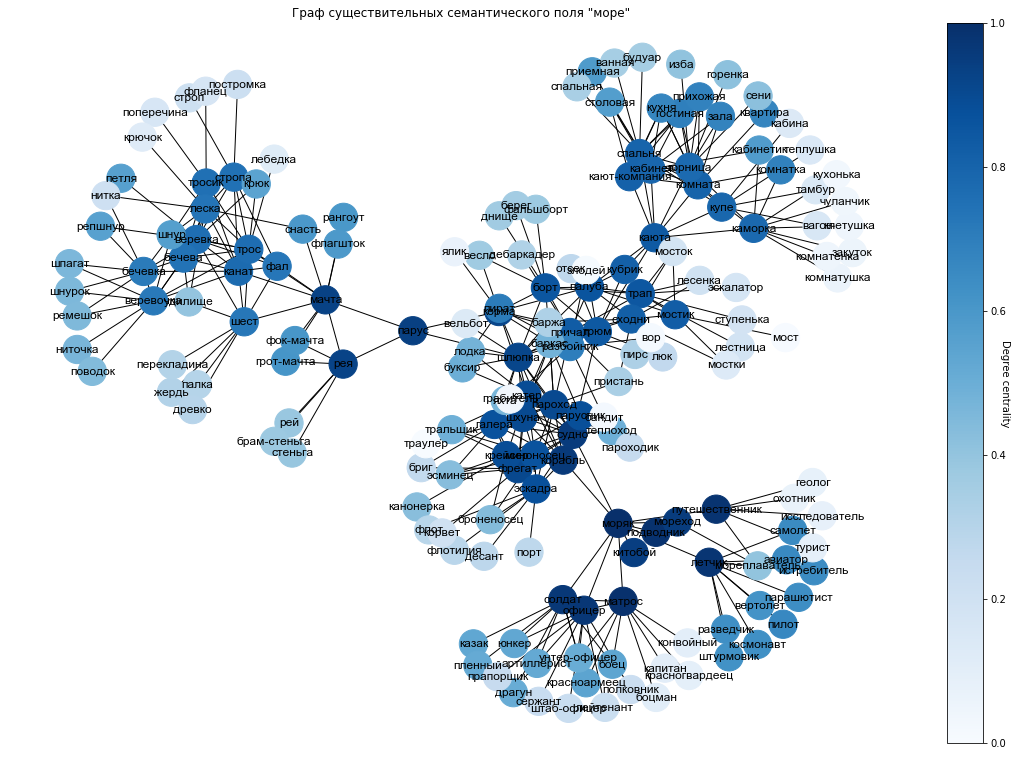

Degree centrality: 
шлюпка
катер
судно
пароход
веревка
причал
комната
горница
трос
корабль


 Betweenness centrality: 
моряк
парус
шлюпка
мачта
каюта
судно
трюм
палуба
корабль
летчик


 Closeness: 
шлюпка
судно
трюм
корабль
корма
палуба
катер
пароход
парус
причал


 Eigenvector_centrality: 
катер
шлюпка
судно
пароход
корабль
шхуна
парусник
галера
баркас
крейсер


 Плотность графа: 0.022597451509635304
Несвязный граф
Несвязный граф
Коэффициент ассортативности: -0.1510381054534967
Коэффициент кластеризации: 0.2660870622421723 


Community 0:  ['авиатор', 'артиллерист', 'боец', 'боцман', 'вертолет', 'геолог', 'драгун', 'исследователь', 'истребитель', 'казак', 'капитан', 'китобой', 'конвойный', 'космонавт', 'красноармеец', 'красногвардеец', 'лейтенант', 'летчик', 'матрос', 'мореплаватель', 'мореход', 'моряк', 'офицер', 'охотник', 'парашютист', 'пилот', 'пленный', 'подводник', 'полковник', 'прапорщик', 'путешественник', 'разведчик', 'самолет', 'сержант', 'солдат', 'турист', 'унтер-офицер', 

In [180]:
main()

### Communities:
1. Названия профессий людей: бандит, пират, разбойник
2. Названия частей судна и разных видов судов: лодка, баржа, корма, трюм, каюта, шлюпка, шхуна
3. Названия снастей: бечева, мачта, леска, рея, шпагат, фок-мачта

Это распределение иллюстрирует, что семантическое поле _*море*_ неоднородное и слишком большое: оно включает в себя подполя, как минимум "люди", "судна", "снасти" и тд. 

In [ ]:
if __name__ == '__main__':
    main()